In [1]:
import numpy as np
import pandas as pd
 
import copy
from collections import Counter
import collections
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
%matplotlib inline
 
from nltk.util import ngrams
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.corpus import wordnet as wn
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
 
import nltk, re, string, collections
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
 
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
from scipy import sparse 
import scipy.sparse
 
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import model_selection, naive_bayes, svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')

import random
import token
from google.colab import files

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Membaca Data

In [ ]:
datasets = pd.read_csv('drive/My Drive/Tugas Akhir/dataset_movie_review.csv')
#datasets['sentiment'] = datasets['sentiment'].replace({'negative': 0, 'positive': 1})
display(datasets.head())

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Mengecek missing values

In [ ]:
datasets.isna().sum()

review       0
sentiment    0
dtype: int64

Mengecek apakah target memiliki imbalance data

positive    25000
negative    25000
Name: sentiment, dtype: int64


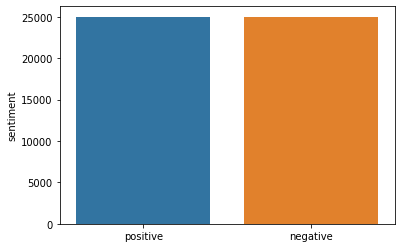

In [ ]:
sentiment_eq = datasets['sentiment'].value_counts()
print(sentiment_eq)
sns.barplot(sentiment_eq.index,sentiment_eq)

Text Preprocessing

Melakukan pembersihan data mulai dari menghilangkan huruf non-alphabetical, tanda baca, dan case folding

In [ ]:
review_data = datasets
re_list = ['https?://\S+|www\.\S+', '<.*?>', 
                           "["u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              u"\U00002702-\U000027B0"
                              u"\U000024C2-\U0001F251"
                           "]+"]
review_data['review'] = review_data['review'].apply(lambda x: re.compile( '|'.join(re_list)).sub(f'', x))
review_data['review'] = review_data['review'].str.replace("[^a-zA-Z#]", " ")
review_data['review'] = review_data['review'].apply(lambda x : " ".join(x.lower() for x in x.split()) )
review_data['review'] = review_data['review'].apply(lambda x: x.replace('#',''))


review_data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there s a family where a little boy ...,negative
4,petter mattei s love in the time of money is a...,positive


berikutnya masuk ke tahap Lemmatization, stopword removal, tag, dan tokenisasi data

In [ ]:
review_data['review'] = [word_tokenize(entry) for entry in review_data['review']]

tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(review_data['review']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    review_data.loc[index,'unigram'] = str(Final_words)

In [ ]:
review_data.head()

,review,sentiment,unigram
0,"[one, of, the, other, reviewers, has, mentione...",positive,"['one', 'reviewer', 'mention', 'watch', 'oz', ..."
1,"[a, wonderful, little, production, the, filmin...",positive,"['wonderful', 'little', 'production', 'filming..."
2,"[i, thought, this, was, a, wonderful, way, to,...",positive,"['think', 'wonderful', 'way', 'spend', 'time',..."
3,"[basically, there, s, a, family, where, a, lit...",negative,"['basically', 'family', 'little', 'boy', 'jake..."
4,"[petter, mattei, s, love, in, the, time, of, m...",positive,"['petter', 'mattei', 'love', 'time', 'money', ..."


In [ ]:
review_data.to_csv('review_data_Preprocessing.csv') 
files.download('review_data_Preprocessing.csv')

Pengecekan dan penyiapan dataset untuk digunakan ke tahap berikutnya

In [2]:
clean_data = pd.read_csv('drive/My Drive/Tugas Akhir/review_data_Preprocessing.csv')
display(clean_data.head())

,Unnamed: 0,review,sentiment,unigram
0,0,"['one', 'of', 'the', 'other', 'reviewers', 'ha...",positive,"['one', 'reviewer', 'mention', 'watch', 'oz', ..."
1,1,"['a', 'wonderful', 'little', 'production', 'th...",positive,"['wonderful', 'little', 'production', 'filming..."
2,2,"['i', 'thought', 'this', 'was', 'a', 'wonderfu...",positive,"['think', 'wonderful', 'way', 'spend', 'time',..."
3,3,"['basically', 'there', 's', 'a', 'family', 'wh...",negative,"['basically', 'family', 'little', 'boy', 'jake..."
4,4,"['petter', 'mattei', 's', 'love', 'in', 'the',...",positive,"['petter', 'mattei', 'love', 'time', 'money', ..."


Memisahkan data kedalam variable X dan y

In [3]:
X = clean_data['unigram']
y = clean_data.sentiment

Encode data

In [4]:
Encoder = LabelEncoder()
y = Encoder.fit_transform(y)

Feature extraction

In [5]:
# banyaknya term yang akan digunakan, 
# di pilih berdasarkan top max_features 
# yang diurutkan berdasarkan term frequency seluruh corpus
max_features = 3000


def generate_tfidf_mat(min_gram, max_gram):
    cvect = CountVectorizer(max_features=max_features, ngram_range=(min_gram, max_gram))
    counts = cvect.fit_transform(X)

    normalized_counts = normalize(counts, norm='l1', axis=1)

    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(min_gram, max_gram), smooth_idf=False)
    tfs = tfidf.fit_transform(X)

    tfidf_mat = normalized_counts.multiply(tfidf.idf_).toarray()
    
    TF = normalized_counts.toarray()
    IDF = tfidf.idf_
    TF_IDF = tfidf_mat
    return TF, IDF, TF_IDF, tfidf.get_feature_names()

# ngram_range (1, 1) to use unigram only
tf_mat_unigram, idf_mat_unigram, tfidf_mat_unigram, terms_unigram = generate_tfidf_mat(1,1)

# ngram_range (2, 2) to use bigram only
tf_mat_bigram, idf_mat_bigram, tfidf_mat_bigram, terms_bigram = generate_tfidf_mat(2,2)

# ngram_range (3, 3) to use trigram only
#tf_mat_trigram, idf_mat_trigram, tfidf_mat_trigram, terms_trigram = generate_tfidf_mat(3,3)


Mengecek sparse data

In [ ]:
#unigram
idx_sample = 1

print("Show TFIDF sample ke-" + str(idx_sample), "\n")
print(X[idx_sample], "\n")

print("\t\t\t", "TF", "\t\t", "IDF", "\t\t", "TF-IDF", "\t", "Term\n")
for i, item in enumerate(zip(tf_mat_unigram[idx_sample], idf_mat_unigram, tfidf_mat_unigram[idx_sample], terms_unigram)):
    if(item[2] != 0.0):
        print ("array position " + str(i) + "\t", 
               "%.6f" % item[0], "\t", 
               "%.6f" % item[1], "\t", 
               "%.6f" % item[2], "\t", 
               item[3])

Show TFIDF sample ke-1 

['a', 'wonderful', 'little', 'production', 'the', 'filming', 'technique', 'is', 'very', 'unassuming', 'very', 'old', 'time', 'bbc', 'fashion', 'and', 'gives', 'a', 'comforting', 'and', 'sometimes', 'discomforting', 'sense', 'of', 'realism', 'to', 'the', 'entire', 'piece', 'the', 'actors', 'are', 'extremely', 'well', 'chosen', 'michael', 'sheen', 'not', 'only', 'has', 'got', 'all', 'the', 'polari', 'but', 'he', 'has', 'all', 'the', 'voices', 'down', 'pat', 'too', 'you', 'can', 'truly', 'see', 'the', 'seamless', 'editing', 'guided', 'by', 'the', 'references', 'to', 'williams', 'diary', 'entries', 'not', 'only', 'is', 'it', 'well', 'worth', 'the', 'watching', 'but', 'it', 'is', 'a', 'terrificly', 'written', 'and', 'performed', 'piece', 'a', 'masterful', 'production', 'about', 'one', 'of', 'the', 'great', 'master', 's', 'of', 'comedy', 'and', 'his', 'life', 'the', 'realism', 'really', 'comes', 'home', 'with', 'the', 'little', 'things', 'the', 'fantasy', 'of', 'the'

In [ ]:
#bigram
idx_sample = 1

print("Show TFIDF sample ke-" + str(idx_sample), "\n")
print(X[idx_sample], "\n")

print("\t\t\t", "TF", "\t\t", "IDF", "\t\t", "TF-IDF", "\t", "Term\n")
for i, item in enumerate(zip(tf_mat_bigram[idx_sample], idf_mat_bigram, tfidf_mat_bigram[idx_sample], terms_bigram)):
    if(item[2] != 0.0):
        print ("array position " + str(i) + "\t", 
               "%.6f" % item[0], "\t", 
               "%.6f" % item[1], "\t", 
               "%.6f" % item[2], "\t", 
               item[3])

Show TFIDF sample ke-1 

['a', 'wonderful', 'little', 'production', 'the', 'filming', 'technique', 'is', 'very', 'unassuming', 'very', 'old', 'time', 'bbc', 'fashion', 'and', 'gives', 'a', 'comforting', 'and', 'sometimes', 'discomforting', 'sense', 'of', 'realism', 'to', 'the', 'entire', 'piece', 'the', 'actors', 'are', 'extremely', 'well', 'chosen', 'michael', 'sheen', 'not', 'only', 'has', 'got', 'all', 'the', 'polari', 'but', 'he', 'has', 'all', 'the', 'voices', 'down', 'pat', 'too', 'you', 'can', 'truly', 'see', 'the', 'seamless', 'editing', 'guided', 'by', 'the', 'references', 'to', 'williams', 'diary', 'entries', 'not', 'only', 'is', 'it', 'well', 'worth', 'the', 'watching', 'but', 'it', 'is', 'a', 'terrificly', 'written', 'and', 'performed', 'piece', 'a', 'masterful', 'production', 'about', 'one', 'of', 'the', 'great', 'master', 's', 'of', 'comedy', 'and', 'his', 'life', 'the', 'realism', 'really', 'comes', 'home', 'with', 'the', 'little', 'things', 'the', 'fantasy', 'of', 'the'

Membuat fungsi untuk menyimpan data ke excel

In [ ]:
def get_TF_unigram(row):
    idx = row.name
    return [tf for tf in tf_mat_unigram[idx] if tf != 0.0]

clean_data["TF_UNIGRAM"] = clean_data.apply(get_TF_unigram, axis=1)

def get_IDF_unigram(row):
    idx = row.name
    return [item[1] for item in zip(tf_mat_unigram[idx], idf_mat_unigram) if item[0] != 0.0]

clean_data["IDF_UNIGRAM"] = clean_data.apply(get_IDF_unigram, axis=1)

def get_TFIDF_unigram(row):
    idx = row.name
    return [tfidf for tfidf in tfidf_mat_unigram[idx] if tfidf != 0.0]

clean_data["TFIDF_UNIGRAM"] = clean_data.apply(get_TFIDF_unigram, axis=1)

clean_data[["unigram", "TF_UNIGRAM", "IDF_UNIGRAM", "TFIDF_UNIGRAM"]].head()

,unigram,TF_UNIGRAM,IDF_UNIGRAM,TFIDF_UNIGRAM
0,"['one', 'reviewer', 'mention', 'watch', 'oz', ...","[0.004016064257028112, 0.004016064257028112, 0...","[1.879235823923144, 2.4818365678403786, 1.6580...","[0.007547131822984513, 0.00996721513188907, 0...."
1,"['wonderful', 'little', 'production', 'filming...","[0.007518796992481203, 0.007518796992481203, 0...","[1.879235823923144, 2.9297809271254422, 1.6580...","[0.01412959266107627, 0.022028428023499566, 0...."
2,"['think', 'wonderful', 'way', 'spend', 'time',...","[0.0070921985815602835, 0.0070921985815602835,...","[4.792463770370507, 5.898199864766467, 1.03461...","[0.033989104754400756, 0.0418312047146558, 0.0..."
3,"['basically', 'family', 'little', 'boy', 'jake...","[0.02912621359223301, 0.038834951456310676, 0....","[1.6580117237916907, 1.0346121489176958, 1.593...","[0.048291603605583225, 0.04017911257932799, 0...."
4,"['petter', 'mattei', 'love', 'time', 'money', ...","[0.010810810810810811, 0.005405405405405406, 0...","[1.879235823923144, 2.5425272071514735, 3.4041...","[0.020316062961331288, 0.013743390308926885, 0..."


In [ ]:
def get_TF_bigram(row):
    idx = row.name
    return [tf for tf in tf_mat_bigram[idx] if tf != 0.0]

clean_data["TF_BIGRAM"] = clean_data.apply(get_TF_bigram, axis=1)

def get_IDF_bigram(row):
    idx = row.name
    return [item[1] for item in zip(tf_mat_bigram[idx], idf_mat_bigram) if item[0] != 0.0]

clean_data["IDF_BIGRAM"] = clean_data.apply(get_IDF_bigram, axis=1)

def get_TFIDF_bigram(row):
    idx = row.name
    return [tfidf for tfidf in tfidf_mat_bigram[idx] if tfidf != 0.0]

clean_data["TFIDF_BIGRAM"] = clean_data.apply(get_TFIDF_bigram, axis=1)

def get_Term_bigram(row):
    idx = row.name
    return [item[1] for item in zip(tf_mat_bigram[idx], terms_bigram) if item[0] != 0.0]

clean_data["bigram"] = clean_data.apply(get_Term_bigram, axis=1)

clean_data[["bigram", "TF_BIGRAM", "IDF_BIGRAM", "TFIDF_BIGRAM"]].head()

,bigram,TF_BIGRAM,IDF_BIGRAM,TFIDF_BIGRAM
0,"[after watching, all the, and get, and more, a...","[0.013157894736842105, 0.013157894736842105, 0...","[5.426187530459651, 2.8821656931040707, 5.4954...","[0.0713972043481533, 0.03792323280400093, 0.07..."
1,"[actors are, all the, and his, and sometimes, ...","[0.023809523809523808, 0.047619047619047616, 0...","[5.318488613869894, 2.8821656931040707, 3.6238...","[0.1266306812826165, 0.13724598538590813, 0.08..."
2,"[and more, and the, at one, be disappointed, b...","[0.0196078431372549, 0.0196078431372549, 0.019...","[4.7297014486341915, 1.9854800512271535, 5.345...","[0.0927392440908665, 0.03893098139661085, 0.10..."
3,"[all the, and then, as for, decides to, film y...","[0.05555555555555555, 0.027777777777777776, 0....","[2.8821656931040707, 3.779331403107174, 5.0008...","[0.16012031628355947, 0.10498142786408815, 0.1..."
4,"[about the, acting is, all these, and the, as ...","[0.014285714285714285, 0.014285714285714285, 0...","[3.2061845987077304, 4.074775480894444, 5.4990...","[0.045802637124396146, 0.05821107829849206, 0...."


In [ ]:
clean_data[["unigram", "TF_UNIGRAM", "IDF_UNIGRAM", "TFIDF_UNIGRAM"]].to_excel("TFIDF_Unigram.xlsx")
clean_data[["bigram", "TF_BIGRAM", "IDF_BIGRAM", "TFIDF_BIGRAM"]].to_excel("TFIDF_Bigram.xlsx")

In [ ]:
files.download('TFIDF_Unigram.xlsx')
files.download('TFIDF_Bigram.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 menyimpan sparse matrix unigram, bigram and trigram ke .npz file

In [ ]:

sparse.save_npz("tfidf_mat_unigram.npz", sparse.csr_matrix(tfidf_mat_unigram))
sparse.save_npz("tfidf_mat_bigram.npz", sparse.csr_matrix(tfidf_mat_bigram))
#sparse.save_npz("tfidf_mat_trigram.npz", sparse.csr_matrix(tfidf_mat_trigram))



In [ ]:
files.download('tfidf_mat_unigram.npz')
files.download('tfidf_mat_bigram.npz')
#files.download('tfidf_mat_trigram.npz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

membaca kembali sparse matrix yang sebelumnya disimpan pada file .npz

In [6]:
tfidf_mat_unigram = scipy.sparse.load_npz('tfidf_mat_unigram.npz').toarray()
tfidf_mat_bigram = scipy.sparse.load_npz('tfidf_mat_bigram.npz').toarray()
#tfidf_mat_trigram = sparse.load_npz('tfidf_mat_trigram.npz').toarray()

Menyimpan nama fitur dalam bentuk .json

In [ ]:
import json

def get_dict_feature_name(terms):
    feature_name = {}
    feature_name['feature'] = terms
    return feature_name


def save_to_json(Data, json_filename):
    with open(json_filename, mode='w') as json_config:
        json.dump(Data, json_config)
        
# save feature name unigram, bigram and trigram as json file
save_to_json( get_dict_feature_name(terms_unigram),"tfidf_feature_name_unigram.json")
save_to_json( get_dict_feature_name(terms_bigram),"tfidf_feature_name_bigram.json")
#save_to_json( get_dict_feature_name(terms_trigram),"tfidf_feature_name_trigram.json")

In [ ]:
files.download('tfidf_feature_name_unigram.json')
files.download('tfidf_feature_name_bigram.json')
#files.download('tfidf_feature_name_trigram.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Mengkalkulasikan Information Gain untuk setiap fitur

In [8]:
# calculate mutual info (MI) / information gain (GI) untuk tiap feature
mi_unigram = mutual_info_classif(tfidf_mat_unigram, y)
mi_bigram = mutual_info_classif(tfidf_mat_bigram, y)
#mi_trigram = mutual_info_classif(tfidf_mat_trigram, y)

# normalisasi (L1) untuk semua hasil perhitungan MI/GI
norm_mi_unigram = mi_unigram/np.max(mi_unigram)
norm_mi_bigram = mi_bigram/np.max(mi_bigram)
#norm_mi_trigram = mi_trigram/np.max(mi_trigram)


Membaca nama fitur yang disimpan sebelumnya pada tahap tfidf

In [7]:
import json

def read_json_feature_name(file_name, Keys):
    with open(file_name) as json_config:
        json_object = json.load(json_config)

    param = []
    for item in json_object:
        if item in Keys:
            param.append(json_object[item])

    return param

terms_unigram = read_json_feature_name("tfidf_feature_name_unigram.json", "feature")
terms_bigram = read_json_feature_name("tfidf_feature_name_bigram.json", "feature")
#terms_trigram = read_json_feature_name("tfidf_feature_name_trigram.json", "feature")

Menampilkan top 10 fitur tf-idf dengan nilai IG nya

In [9]:
# sum tfidf frequency of each term through documents
sums_unigram = tfidf_mat_unigram.sum(axis=0)
sums_bigram = tfidf_mat_bigram.sum(axis=0)
#sums_trigram = tfidf_mat_trigram.sum(axis=0)

def generate_ranking(terms, sums):
    # connecting term to its sums frequency
    data = []
    for col, term in enumerate(terms):
        data.append((term, sums[col] ))
    ranking = pd.DataFrame(data, columns=['term','rank'])
    return ranking.sort_values('rank', ascending=False)


ranking_unigram = generate_ranking(terms_unigram[0], sums_unigram)
ranking_bigram = generate_ranking(terms_bigram[0], sums_bigram)
#ranking_trigram = generate_ranking(terms_trigram[0], sums_trigram)

In [10]:
# apply norm_mi to Dataframe rangking
ranking_unigram["MI_unigram"] = ranking_unigram.apply(lambda x: norm_mi_unigram[x.name], axis=1)
ranking_bigram["MI_bigram"] = ranking_bigram.apply(lambda x: norm_mi_bigram[x.name], axis=1)
#ranking_trigram["MI_trigram"] = ranking_trigram.apply(lambda x: norm_mi_trigram[x.name], axis=1)

In [11]:
# show top 10 rank (total tfidf) unigram
ranking_unigram.head(10)

,term,rank,MI_unigram
1739,movie,1895.999964,0.117946
1008,film,1566.057417,0.032158
1861,one,936.937617,0.000000
2326,see,852.483626,0.041382
1536,like,829.923548,0.010624
1605,make,819.363278,0.052454
1141,good,804.908416,0.063581
203,bad,720.242410,1.000000
2905,watch,707.697694,0.006161
1123,get,699.286832,0.028797


In [12]:
# show top 10 rank (total tfidf) bigram
ranking_bigram.head(10)

,term,rank,MI_bigram
1382,look like,964.357314,0.551287
554,ever see,856.789223,0.239913
2814,watch movie,848.442271,0.130362
2315,see movie,794.490830,0.000000
2981,year old,772.115022,0.100446
170,bad movie,764.114383,1.000000
2439,special effect,720.358012,0.000000
1871,one best,689.782002,0.546351
1466,make movie,646.169744,0.054333
1042,good movie,616.188363,0.000000


Pengaplikasian nilai threshold pada IG

In [13]:
# get all column index on norm_mi below 0.01 
def get_column_idx(norm_mi, threshold):
    return [i for i, mi_item in enumerate(norm_mi) if mi_item < threshold]

column_idx_unigram = get_column_idx(norm_mi_unigram, 0.01)
column_idx_bigram = get_column_idx(norm_mi_bigram, 0.01)
#column_idx_trigram = get_column_idx(norm_mi_trigram, 0.1)


# delete sparse matrix tfidf_mat where column=column_id, save into new array
tfidf_mat_selection_unigram = np.delete(tfidf_mat_unigram, column_idx_unigram ,1)
tfidf_mat_selection_bigram = np.delete(tfidf_mat_bigram, column_idx_bigram ,1)
#tfidf_mat_selection_trigram = np.delete(tfidf_mat_trigram, column_idx_trigram ,1)

# number of feature after reduction
max_features_unigram = tfidf_mat_selection_unigram.shape[1]
max_features_bigram = tfidf_mat_selection_bigram.shape[1]
#max_features_trigram = tfidf_mat_selection_trigram.shape[1]

Menampilkan fitur yang diseleksi oleh IG

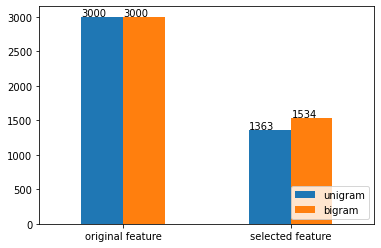

In [14]:
# plot number of feature on bar chart
groups = [[tfidf_mat_unigram.shape[1], 
           tfidf_mat_bigram.shape[1]], 
          
          [tfidf_mat_selection_unigram.shape[1], 
           tfidf_mat_selection_bigram.shape[1]]]

group_labels = ['original feature', 'selected feature']

# Convert data to pandas DataFrame.
df = pd.DataFrame(groups, index=group_labels, columns=["unigram", "bigram"])

# plot into bar chart
ax = df.plot(kind='bar', rot=0) 
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

ax.legend(loc='lower right')

Menyimpan sparse matrix dari hasil IG untuk digunakan pada tahap klasifikasi

In [15]:
# save sparse matrix unigram, bigram and trigram to .npz file
sparse.save_npz("tfidf_mat_selection_unigram.npz", sparse.csr_matrix(tfidf_mat_selection_unigram))
sparse.save_npz("tfidf_mat_selection_bigram.npz", sparse.csr_matrix(tfidf_mat_selection_bigram))
#sparse.save_npz("tfidf_mat_selection_trigram.npz", sparse.csr_matrix(tfidf_mat_selection_trigram))

In [ ]:
files.download('tfidf_mat_selection_unigram.npz')
files.download('tfidf_mat_selection_bigram.npz')
#files.download('tfidf_mat_selection_trigram.npz')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Information gain

Membaca sparse matrix dan tags dari IG untuk unigram dan bigram

In [16]:
# ---------------------- Get Sparse Matrix & Tags , Unigram, BIgram and Trigram ------------------
def get_sparse_n_tags(file_names, dataset_name):
    
    # load preprocessed dataset as dataframe
    tags = clean_data.sentiment
    
    # load sparse matrix
    unigram = sparse.load_npz(file_names[0]).toarray()
    bigram = sparse.load_npz(file_names[1]).toarray()
    #trigram = sparse.load_npz(file_names[2]).toarray()
    
    return [unigram, bigram, tags]

sparse_file_names = [
                    "tfidf_mat_selection_unigram.npz",
                    "tfidf_mat_selection_bigram.npz"]
preprocessed_dataset_name = y

sparse_unigram, sparse_bigram, tags = \
                        get_sparse_n_tags(sparse_file_names, preprocessed_dataset_name)

In [17]:
sparse_unigram.shape, sparse_bigram.shape

((50000, 1363), (50000, 1534))

SPLIT DATA

In [18]:
# ---------------------------- SPLIT DATASET -----------------------------------------------
def split_dataset(sparse, tags, split_ratio):
    # split dataset 
    return train_test_split(sparse, tags, test_size=split_ratio, random_state=42) 

sparse_unigram_train, sparse_unigram_test, tags_train, tags_test = split_dataset(sparse_unigram, tags, 0.3)
sparse_bigram_train, sparse_bigram_test, tags_train, tags_test = split_dataset(sparse_bigram, tags, 0.3)
#sparse_trigram_train, sparse_trigram_test, tags_train, tags_test = split_dataset(sparse_trigram, tags, 0.3)


Klasifikasi MultinomialNB

Unigram

In [19]:
nb_ig = MultinomialNB()
nb_ig.fit(sparse_unigram_train,tags_train)  

#Predict y value for test dataset
y_pred = nb_ig.predict(sparse_unigram_test)
y_prob = nb_ig.predict_proba(sparse_unigram_test)
print(classification_report(tags_test, y_pred))
print('Confusion Matrix:\n',metrics.confusion_matrix(tags_test, y_pred))

avg_score = (cross_val_score(nb_ig, sparse_unigram_test, tags_test, cv=5))

print("\n %0.3f accuracy with a standard deviation of %0.3f" % (avg_score.mean(), avg_score.std()))
 

              precision    recall  f1-score   support

    negative       0.85      0.84      0.85      7411
    positive       0.85      0.86      0.85      7589

    accuracy                           0.85     15000
   macro avg       0.85      0.85      0.85     15000
weighted avg       0.85      0.85      0.85     15000

Confusion Matrix:
 [[6240 1171]
 [1095 6494]]

 0.846 accuracy with a standard deviation of 0.005


Bigram

In [20]:
nb_ig = MultinomialNB()
nb_ig.fit(sparse_bigram_train,tags_train)  

#Predict y value for test dataset
y_pred = nb_ig.predict(sparse_bigram_test)
y_prob = nb_ig.predict_proba(sparse_bigram_test)
print(classification_report(tags_test, y_pred))

print('Confusion Matrix:\n',metrics.confusion_matrix(tags_test, y_pred))

avg_score = (cross_val_score(nb_ig, sparse_bigram_test, tags_test, cv=5))

print("\n %0.3f accuracy with a standard deviation of %0.3f" % (avg_score.mean(), avg_score.std()))

              precision    recall  f1-score   support

    negative       0.76      0.78      0.77      7411
    positive       0.78      0.76      0.77      7589

    accuracy                           0.77     15000
   macro avg       0.77      0.77      0.77     15000
weighted avg       0.77      0.77      0.77     15000

Confusion Matrix:
 [[5749 1662]
 [1834 5755]]

 0.760 accuracy with a standard deviation of 0.006


klasifikasi SVM

Unigram


In [21]:
svc = LinearSVC()
svc.fit(sparse_unigram_train, tags_train)

y_true = tags_test
y_pred = svc.predict(sparse_unigram_test)

print(classification_report(tags_test, y_pred))
print('Confusion Matrix:\n',metrics.confusion_matrix(tags_test, y_pred))

avg_score = (cross_val_score(svc, sparse_unigram_test, tags_test, cv=5))

print("\n %0.3f accuracy with a standard deviation of %0.3f" % (avg_score.mean(), avg_score.std()))


              precision    recall  f1-score   support

    negative       0.88      0.86      0.87      7411
    positive       0.86      0.89      0.88      7589

    accuracy                           0.87     15000
   macro avg       0.87      0.87      0.87     15000
weighted avg       0.87      0.87      0.87     15000

Confusion Matrix:
 [[6361 1050]
 [ 868 6721]]

 0.862 accuracy with a standard deviation of 0.005


Bigram

In [22]:
svc = LinearSVC()
svc.fit(sparse_bigram_train, tags_train)

y_true = tags_test
y_pred = svc.predict(sparse_bigram_test)

print(metrics.classification_report(tags_test, y_pred))
print('Confusion Matrix:\n', metrics.confusion_matrix(tags_test, y_pred))

avg_score = (cross_val_score(svc, sparse_bigram_test, tags_test, cv=5))
print("\n %0.3f accuracy with a standard deviation of %0.3f" % (avg_score.mean(), avg_score.std()))


              precision    recall  f1-score   support

    negative       0.78      0.74      0.76      7411
    positive       0.76      0.80      0.78      7589

    accuracy                           0.77     15000
   macro avg       0.77      0.77      0.77     15000
weighted avg       0.77      0.77      0.77     15000

Confusion Matrix:
 [[5455 1956]
 [1510 6079]]

 0.747 accuracy with a standard deviation of 0.007
